# Imports

In [ ]:
!pip install wandb -qU
%pip install chess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=924893f3423acf8b63b1c4f15ef2e4355fbfef8d19b77583642d15f7c67d1645
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [ ]:
import wandb
wandb.require("core")

wandb.login()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import chess
from chess import pgn

In [ ]:
import os # to delete old files

In [ ]:
import random

# Matrices to games

In [ ]:
def tensor_to_board(tensor):
    board = chess.Board()
    board.clear()
    idx_to_piece = [
        chess.PAWN,
        chess.KNIGHT,
        chess.BISHOP,
        chess.ROOK,
        chess.QUEEN,
        chess.KING,
    ]
    for row in range(8):
        for col in range(8):
            for piece_idx in range(6):
                white_offset = 0
                piece_is_here = tensor[row][col][piece_idx + white_offset]
                if piece_is_here:
                    piece = idx_to_piece[piece_idx]
                    board.set_piece_at(
                        chess.square(col, row), chess.Piece(piece, chess.WHITE)
                    )

                black_offset = 6
                piece_is_here = tensor[row][col][piece_idx + black_offset]
                if piece_is_here:
                    piece = idx_to_piece[piece_idx]
                    board.set_piece_at(
                        chess.square(col, row), chess.Piece(piece, chess.BLACK)
                    )
    return board


def info_to_move(from_square, to_square, promotion=None):
    move = chess.Move(from_square, to_square)
    if promotion:
        if promotion == chess.QUEEN:
            move.promotion = chess.QUEEN
        elif promotion == chess.BISHOP:
            move.promotion = chess.BISHOP
        elif promotion == chess.ROOK:
            move.promotion = chess.ROOK
        elif promotion == chess.KNIGHT:
            move.promotion = chess.KNIGHT
    return move


def tensor_to_move(tensor, color):
    tensor_8_8_76_form = tensor.view(8, 8, 76)
    for row in range(8):
        for col in range(8):
            promotion = None
            from_square = chess.square(col, row)
            for i in range(64, 67):
                if tensor_8_8_76_form[row][col][i]:
                    promotion = chess.KNIGHT
                    to_square = chess.square(
                        col - 65 + i, row + 1 if color == chess.WHITE else row - 1
                    )
                    return info_to_move(from_square, to_square, promotion)
            for i in range(67, 70):
                if tensor_8_8_76_form[row][col][i]:
                    promotion = chess.ROOK
                    to_square = chess.square(
                        col - 68 + i, row + 1 if color == chess.WHITE else row - 1
                    )
                    return info_to_move(from_square, to_square, promotion)
            for i in range(70, 73):
                if tensor_8_8_76_form[row][col][i]:
                    promotion = chess.BISHOP
                    to_square = chess.square(
                        col - 71 + i, row + 1 if color == chess.WHITE else row - 1
                    )
                    return info_to_move(from_square, to_square, promotion)
            for i in range(73, 76):
                if tensor_8_8_76_form[row][col][i]:
                    promotion = chess.QUEEN
                    to_square = chess.square(
                        col - 74 + i, row + 1 if color == chess.WHITE else row - 1
                    )
                    return info_to_move(from_square, to_square, promotion)
            for i in range(7, 56, 8):
                if tensor_8_8_76_form[row][col][i]:
                    to_square = chess.square(col + i // 8 + 1, row + i // 8 + 1)
                    return info_to_move(from_square, to_square)
            for i in range(3, 52, 8):
                if tensor_8_8_76_form[row][col][i]:
                    to_square = chess.square(col - i // 8 - 1, row - i // 8 - 1)
                    return info_to_move(from_square, to_square)
            for i in range(1, 50, 8):
                if tensor_8_8_76_form[row][col][i]:
                    to_square = chess.square(col - i // 8 - 1, row + i // 8 + 1)
                    return info_to_move(from_square, to_square)
            for i in range(5, 54, 8):
                if tensor_8_8_76_form[row][col][i]:
                    to_square = chess.square(col + i // 8 + 1, row - i // 8 - 1)
                    return info_to_move(from_square, to_square)
            for i in range(6, 55, 8):
                if tensor_8_8_76_form[row][col][i]:
                    to_square = chess.square(col + i // 8 + 1, row)
                    return info_to_move(from_square, to_square)
            for i in range(2, 51, 8):
                if tensor_8_8_76_form[row][col][i]:
                    to_square = chess.square(col - i // 8 - 1, row)
                    return info_to_move(from_square, to_square)
            for i in range(0, 49, 8):
                if tensor_8_8_76_form[row][col][i]:
                    to_square = chess.square(col, row + i // 8 + 1)
                    return info_to_move(from_square, to_square)
            for i in range(4, 53, 8):
                if tensor_8_8_76_form[row][col][i]:
                    to_square = chess.square(col, row - i // 8 - 1)
                    return info_to_move(from_square, to_square)
            if tensor_8_8_76_form[row][col][56]:
                to_square = chess.square(col - 1, row + 2)
                return info_to_move(from_square, to_square)
            if tensor_8_8_76_form[row][col][57]:
                to_square = chess.square(col - 2, row + 1)
                return info_to_move(from_square, to_square)
            if tensor_8_8_76_form[row][col][58]:
                to_square = chess.square(col - 2, row - 1)
                return info_to_move(from_square, to_square)
            if tensor_8_8_76_form[row][col][59]:
                to_square = chess.square(col - 1, row - 2)
                return info_to_move(from_square, to_square)
            if tensor_8_8_76_form[row][col][60]:
                to_square = chess.square(col + 1, row - 2)
                return info_to_move(from_square, to_square)
            if tensor_8_8_76_form[row][col][61]:
                to_square = chess.square(col + 2, row - 1)
                return info_to_move(from_square, to_square)
            if tensor_8_8_76_form[row][col][62]:
                to_square = chess.square(col + 2, row + 1)
                return info_to_move(from_square, to_square)
            if tensor_8_8_76_form[row][col][63]:
                to_square = chess.square(col + 1, row + 2)
                return info_to_move(from_square, to_square)
    print("Can't convert a tensor to a move")

# Games to matrices

In [ ]:
ELO_RANGES = [
    800,
    # 1200,
    # 1600,
    # 2000,
    # 2400,
]
NUM_FOR_SINGLE_OF_ELO_RANGE = 4000
ELO_RANGE_MUL = [
    1,
    # 2,
    # 4,
    # 4,
    # 3,
]


def game_to_tensor(game: pgn.GameNode) -> tuple[torch.Tensor, torch.Tensor]:
    # Initialize an 8x8x12 tensor with zeros
    tensor = torch.zeros(8, 8, 12)

    # Mapping of pieces to tensor indices
    piece_to_idx = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5,
    }

    # Current player color
    color = game.turn()

    # Iterate over the board and set the tensor values
    for i in range(64):
        piece = game.board().piece_at(i)
        if piece:
            color_offset = 0 if piece.color == color else 6
            piece_idx = piece_to_idx[piece.piece_type]
            row, col = divmod(i, 8)
            tensor[row, col, color_offset + piece_idx] = 1

    # Add the additional binary features
    queen_castling_right = bool(
        game.board().castling_rights & (chess.BB_A1 if color else chess.BB_A8)
    )
    king_castling_right = bool(
        game.board().castling_rights & (chess.BB_H1 if color else chess.BB_H8)
    )
    consts = torch.tensor(
        [
            queen_castling_right,
            king_castling_right,
            1 if game.turn() == chess.WHITE else 0,
        ]
    )

    return tensor, consts


def move_to_tensor(move: chess.Move) -> torch.Tensor:
    from_sq, to_sq = move.from_square, move.to_square
    from_row, from_col = divmod(from_sq, 8)
    to_row, to_col = divmod(to_sq, 8)

    promotion_tensor = torch.zeros(8, 8, 12)
    queen_moves_tensor = torch.zeros(8, 8, 56)
    knight_moves_tensor = torch.zeros(8, 8, 8)
    if move.promotion:
        if move.promotion == chess.QUEEN:
            promotion_tensor[from_row][from_col][10 + to_col - from_col] = 1
        elif move.promotion == chess.BISHOP:
            promotion_tensor[from_row][from_col][7 + to_col - from_col] = 1
        elif move.promotion == chess.ROOK:
            promotion_tensor[from_row][from_col][4 + to_col - from_col] = 1
        elif move.promotion == chess.KNIGHT:
            promotion_tensor[from_row][from_col][1 + to_col - from_col] = 1
    elif from_row - to_row == from_col - to_col:
        if from_row < to_row:
            queen_moves_tensor[from_row][from_col][
                7 + (abs(from_col - to_col) - 1) * 8
            ] = 1
        else:
            queen_moves_tensor[from_row][from_col][
                3 + (abs(from_col - to_col) - 1) * 8
            ] = 1
    elif from_row - to_row == to_col - from_col:
        if from_row < to_row:
            queen_moves_tensor[from_row][from_col][
                1 + (abs(from_col - to_col) - 1) * 8
            ] = 1
        else:
            queen_moves_tensor[from_row][from_col][
                5 + (abs(from_col - to_col) - 1) * 8
            ] = 1
    elif from_row == to_row:
        if from_col < to_col:
            queen_moves_tensor[from_row][from_col][
                6 + (abs(from_col - to_col) - 1) * 8
            ] = 1
        else:
            queen_moves_tensor[from_row][from_col][
                2 + (abs(from_col - to_col) - 1) * 8
            ] = 1
    elif from_col == to_col:
        if from_row < to_row:
            queen_moves_tensor[from_row][from_col][
                0 + (abs(from_row - to_row) - 1) * 8
            ] = 1
        else:
            queen_moves_tensor[from_row][from_col][
                4 + (abs(from_row - to_row) - 1) * 8
            ] = 1
    elif from_row - to_row == -2:
        if from_col - to_col == -1:
            knight_moves_tensor[from_row][from_col][7] = 1
        else:
            knight_moves_tensor[from_row][from_col][0] = 1
    elif from_row - to_row == 2:
        if from_col - to_col == -1:
            knight_moves_tensor[from_row][from_col][4] = 1
        else:
            knight_moves_tensor[from_row][from_col][3] = 1
    elif from_row - to_row == -1:
        if from_col - to_col == -2:
            knight_moves_tensor[from_row][from_col][6] = 1
        else:
            knight_moves_tensor[from_row][from_col][1] = 1
    else:
        if from_col - to_col == -2:
            knight_moves_tensor[from_row][from_col][5] = 1
        else:
            knight_moves_tensor[from_row][from_col][2] = 1

    one_hot = torch.cat(
        (queen_moves_tensor, knight_moves_tensor, promotion_tensor),
        dim=2,
    )

    return torch.argmax(one_hot)


# Data preparation

In [ ]:
RATING = 2400
PART_OF_THIS_RATING = 2

RATING_RANGE = f"{RATING}-{RATING+400}{'' if not PART_OF_THIS_RATING else f'-{PART_OF_THIS_RATING}'}"
print(RATING_RANGE)

2400-2800-2


In [ ]:
DIR = "/drive/MyDrive/Colab Notebooks"
DATA_DIR = f"{DIR}/tensors"
SAVE_DIR = f"{DIR}/chess_ai"

In [ ]:
from google.colab import drive
drive.mount('/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
states = torch.load(f"{DATA_DIR}/states_tensors_{RATING_RANGE}.pt", map_location=device)
print(f"{states.size() = }")
states_consts = torch.load(f"{DATA_DIR}/states_consts_tensors_{RATING_RANGE}.pt", map_location=device)
print(f"{states_consts.size() = }")
moves = torch.load(f"{DATA_DIR}/moves_tensors_{RATING_RANGE}.pt", map_location=device)
print(f"{moves.size() = }")

<ipython-input-14-111e0b1e803f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(f"{DATA_DIR}/states_tensors_{RATING_RANGE}.pt", map_location=device)


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/tensors/states_tensors_2400-2800-2.pt'

In [ ]:
class ChessDataset(Dataset):
    def __init__(self, states, states_consts, moves):
        self.states = states
        self.states_consts = states_consts
        self.moves = moves

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        # one_hot_move = torch.zeros(4864)
        # one_hot_move[self.moves[idx]] = 1
        state = self.states[idx].permute(2, 0, 1)  # Change to [12, 8, 8]
        state_const = self.states_consts[idx]
        move = self.moves[idx]
        return state, state_const, move

# Create dataset
chess_dataset = ChessDataset(states, states_consts, moves)

# DataLoader
dataloader = DataLoader(chess_dataset, batch_size=64, shuffle=True, drop_last=True)

NameError: name 'states' is not defined

# Predict move

## Variables

## Model creation

In [ ]:
class ChessAI(nn.Module):
    def __init__(self):
        super(ChessAI, self).__init__()
        self.conv1 = nn.Conv2d(12, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(1024)
        self.fc1 = nn.Linear(1024 * 2 * 2, 2048)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048 + 3, 1024)  # Adding 3 for additional parameters
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 4864)

    def forward(self, x, params):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 1024 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.cat((x, params), 1)  # Combine board representation with additional parameters
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


class ChessAISmaller(nn.Module):
    def __init__(self):
        super(ChessAISmaller, self).__init__()
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.ln1 = nn.LayerNorm([64, 8, 8])
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm([128, 4, 4])
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.ln3 = nn.LayerNorm([256, 2, 2])
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256 + 3, 512)  # Adding 3 for additional parameters
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 4864)

    def forward(self, x, params):
        x = F.relu(self.ln1(self.conv1(x)))
        x = F.max_pool2d(x, (2, 2))

        x = F.relu(self.ln2(self.conv2(x)))
        x = F.max_pool2d(x, (2, 2))

        x = F.relu(self.ln3(self.conv3(x)))
        x = self.global_avg_pool(x).view(-1, 256)
        x = torch.cat((x, params), 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

model = ChessAISmaller()
model.apply(init_weights)
model.to(device)

ChessAISmaller(
  (conv1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln1): LayerNorm((64, 8, 8), eps=1e-05, elementwise_affine=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln2): LayerNorm((128, 4, 4), eps=1e-05, elementwise_affine=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ln3): LayerNorm((256, 2, 2), eps=1e-05, elementwise_affine=True)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=259, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=4864, bias=True)
)

In [ ]:
# print the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

3,018,688 total parameters.


In [ ]:
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden_dim):
        super().__init__()

        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.ff_hidden_dim = ff_hidden_dim

        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim, num_heads=num_heads, dropout=dropout
        )

        self.pre_norm = nn.LayerNorm(embed_dim)
        self.mlp_norm = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(self.embed_dim, self.ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(self.ff_hidden_dim, self.embed_dim),
        )

    def forward(self, x):
        x_n = self.pre_norm(x)

        x = x + self.attention(x_n, x_n, x_n)

        x = x + self.mlp(self.mlp_norm(x))

        return x
class Transformer(nn.Module):
    def __init__(self,
                 embed_dim = 8,
                 ff_hidden_dim = 32,
                 num_heads = 2,
                 n_layers = 8,
                 ) -> None:
        super().__init__()

        self.piece_embeddings = nn.Embedding(6, embed_dim)
        self.player_embeddings = nn.Embedding(2, embed_dim)
        self.position_embeddings = nn.Embedding(64, embed_dim)
        self.tower = nn.Sequential(
            *(DecoderLayer(embed_dim, num_heads, ff_hidden_dim) for _ in range(n_layers))
        )
        self.ln_f = nn.LayerNorm(embed_dim)
        self.start_unembedding = nn.Linear(embed_dim, 64, bias=False)
        self.target_unembedding = nn.Linear(embed_dim, 64, bias=False)

    def parameter_count(self) -> int:
        return sum(p.numel() for p in self.parameters())

    def forward(
        self,
        pieces: torch.Tensor,
        positions: torch.Tensor,
        players: torch.Tensor,
        piece_targets: torch.Tensor | None = None,
        target_targets: torch.Tensor | None = None,
        piece_to_move: torch.Tensor | None = None,
    ):
        e = (
            self.piece_embeddings(pieces)
            + self.position_embeddings(positions)
            + self.player_embeddings(players)
        )
        e = self.tower(e)
        e = self.ln_f(e)

        piece_logits = self.start_unembedding(e)
        target_logits = self.target_unembedding(e)

        # Average the piece logits over the sequence dimension
        piece_logits = piece_logits.mean(dim=1)

        if piece_targets is None or target_targets is None or piece_to_move is None:
            return piece_logits, target_logits

        # target_logits is of shape (batch_size, seq_len, 64)
        # piece_to_move is of shape (batch_size, seq_len)
        # We want to multiply them, zeroing out the logits for all squares except the source square
        target_logits = target_logits * piece_to_move.unsqueeze(2)

        # Now, we want to sum them into (batch_size, 64) to be able to calculate the loss
        target_logits = target_logits.sum(dim=1)

        piece_loss = F.cross_entropy(piece_logits, piece_targets)
        target_loss = F.cross_entropy(target_logits, target_targets)

        return piece_loss + target_loss

## Train

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="chess_ai_2",

    # track hyperparameters and run metadata
    config={
        "learning_rate": optimizer.param_groups[0]["lr"],
        "architecture": "CNN",
        "dataset": "lichess 2020.11",
        "model": "ChessAISmaller"
    }
)

In [ ]:
EPOCHS = 10
STEP_TO_SAVE = 5000
STEP_TO_PRINT_LOSS = 2500

INITIAL_EPOCH = 20

SCHEDULER_ON = False

In [ ]:
def save_model(model, optimizer, epoch="latest", batch="latest"):
    print("Saving model...", end=" ")
    torch.save(model.state_dict(), f"{SAVE_DIR}/model_parameters_{RATING_RANGE}_epoch{epoch}_batch{batch}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch,
        'batch': batch,
    }, f'{SAVE_DIR}/model_and_optimizer_{RATING_RANGE}_epoch{epoch}.pth')
    print("Done!")
    if batch % STEP_TO_SAVE != 0:
        batch = batch - batch%STEP_TO_SAVE + STEP_TO_SAVE
    if batch != "latest" and batch - STEP_TO_SAVE > 0:
        print(f"Trying to remove {SAVE_DIR}/model_parameters_{RATING_RANGE}_epoch{epoch}_batch{batch-STEP_TO_SAVE}.pth")
        try:
            os.remove(f"{SAVE_DIR}/model_parameters_{RATING_RANGE}_epoch{epoch}_batch{batch-STEP_TO_SAVE}.pth")
            print("Removed")
        except FileNotFoundError:
            print("File not found")
    if batch != "latest" and epoch > INITIAL_EPOCH + 1:
        print(f"Trying to remove {SAVE_DIR}/model_and_optimizer_{RATING_RANGE}_epoch{int(epoch)-1}.pth")
        try:
            os.remove(f'{SAVE_DIR}/model_and_optimizer_{RATING_RANGE}_epoch{int(epoch)-1}.pth')
            print("Removed")
        except FileNotFoundError:
            print("File not found")

def top_k_accuracy(output, target, k=10):
    _, pred = output.topk(k, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return correct[:k].float().sum(0, keepdim=True).mean().item()

In [ ]:
wandb.log({"rating": RATING})
wandb.log({"learning_rate": optimizer.param_groups[0]['lr']})
for epoch in range(INITIAL_EPOCH, EPOCHS+INITIAL_EPOCH):
    wandb.log({"epoch": epoch})
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, consts, labels = data[0].to(device), data[1].to(device), data[2].to(device)

        optimizer.zero_grad()

        outputs = model(inputs, consts)
        loss = loss_function(outputs, labels.long())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        top_1_acc = top_k_accuracy(outputs, labels, k=1)
        top_5_acc = top_k_accuracy(outputs, labels, k=5)

        wandb.log({"loss": loss.item(), "top_1_accuracy": top_1_acc, "top_5_accuracy": top_5_acc})

        running_loss += loss.item()

        if i % STEP_TO_PRINT_LOSS == 0 and i != 0:
            print(f"Epoch: {epoch: >2} | Batch: {i: >5} | loss: {running_loss / STEP_TO_PRINT_LOSS:.3f}")
            running_loss = 0.0

        if i % STEP_TO_SAVE == 0 and i != 0:
            save_model(model, optimizer, epoch, i)
    if SCHEDULER_ON:
        scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    wandb.log({"learning_rate": current_lr})
    save_model(model, optimizer, epoch=epoch, batch=i)
print("Finished Training")

Epoch: 20 | Batch:  2500 | loss: 3.199
Epoch: 20 | Batch:  5000 | loss: 3.183
Saving model... Done!
Epoch: 20 | Batch:  7500 | loss: 3.176
Epoch: 20 | Batch: 10000 | loss: 3.165
Saving model... Done!
Trying to remove drive/MyDrive/Colab Notebooks/chess_ai/model_parameters_2400-2800-2_epoch20_batch5000.pth
Removed
Saving model... Done!
Trying to remove drive/MyDrive/Colab Notebooks/chess_ai/model_parameters_2400-2800-2_epoch20_batch10000.pth
Removed
Epoch: 21 | Batch:  2500 | loss: 3.107
Epoch: 21 | Batch:  5000 | loss: 3.109
Saving model... Done!
Epoch: 21 | Batch:  7500 | loss: 3.105
Epoch: 21 | Batch: 10000 | loss: 3.117
Saving model... Done!
Trying to remove drive/MyDrive/Colab Notebooks/chess_ai/model_parameters_2400-2800-2_epoch21_batch5000.pth
Removed
Saving model... Done!
Trying to remove drive/MyDrive/Colab Notebooks/chess_ai/model_parameters_2400-2800-2_epoch21_batch10000.pth
Removed
Epoch: 22 | Batch:  2500 | loss: 3.050
Epoch: 22 | Batch:  5000 | loss: 3.066
Saving model... 

In [ ]:
save_model(model, optimizer)

Saving model... Done!
Trying to remove drive/MyDrive/Colab Notebooks/chess_ai/model_parameters_2000-2400-5_epoch5_batch5000.pth
File not found


## To load saved model

In [ ]:
# Create all the vars
model = ChessAISmaller()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

In [ ]:
RATING_TO_LOAD = 1600
PART_OF_RATING_TO_LOAD = 2
RATING_TO_LOAD_RANGE = f"{RATING_TO_LOAD}-{RATING_TO_LOAD+400}{'' if not PART_OF_RATING_TO_LOAD else f'-{PART_OF_RATING_TO_LOAD}'}"

EPOCH_TO_LOAD = 15

In [ ]:
# SAVE_DIR="."

In [ ]:
# Load saved state dict
BATCH_TO_LOAD = 15000
# model.load_state_dict(torch.load(f"{SAVE_DIR}/model_parameters_{RATING_TO_LOAD_RANGE}_epoch{EPOCH_TO_LOAD}_batch{BATCH_TO_LOAD}.pth", map_location=device))
model.load_state_dict(torch.load(f"{SAVE_DIR}/model_parameters.pth", map_location=device))

<ipython-input-13-9edec776f992>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{SAVE_DIR}/model_parameters.pth", map_location=device))


<All keys matched successfully>

In [ ]:
# Load a model and the optimizer+scheduler state together
checkpoint = torch.load(f'{SAVE_DIR}/model_and_optimizer_{RATING_TO_LOAD_RANGE}_epoch{EPOCH_TO_LOAD}.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=EPOCH_TO_LOAD-1) # if not saved with scheduler
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<ipython-input-14-df37dac474ee>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{SAVE_DIR}/model_and_optimizer_{RATING_TO_LOAD_RANGE}_epoch{EPOCH_

FileNotFoundError: [Errno 2] No such file or directory: './model_and_optimizer_1600-2000-2_epoch15.pth'

In [ ]:
# To set learning rate
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

new_rate = 0.0001
for param_group in optimizer.param_groups:
    param_group['lr'] = new_rate
scheduler.base_lrs = [new_rate] * len(scheduler.base_lrs)

print(f"New learning rate: {optimizer.param_groups[0]['lr']}")

Current learning rate: 0.0001
New learning rate: 0.0001


## Use model

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1

In [ ]:
fen = input("Enter starting FEN: ")
board = chess.Board(fen=fen)
game = pgn.Game.from_board(board)
initial_game = game

print(game.board())

Enter starting FEN: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [ ]:
def get_move(game):
    move_str = input("Enter move: ")
    if move_str == "q":
        exit()
    try:
        move = chess.Move.from_uci(move_str)
    except ValueError:
        print("Invalid move")
        return get_move(game)
    if move not in game.board().legal_moves:
        print("Illegal move")
        return get_move(game)
    return move


def get_bot_move():
    state, consts = game_to_tensor(game)
    state = (
        state.permute(2, 0, 1).unsqueeze(0).to(device)
    )  # Adds a batch dimension and moves to the device
    consts = consts.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        raw_output = model(state, consts)
        probabilities = torch.softmax(raw_output, dim=1)
        # sort by probability and get the first legal move
        _, sorted_indices = torch.sort(probabilities, descending=True)
        for i in range(sorted_indices.size(1)):
            one_hot = torch.zeros(sorted_indices.size(1))
            one_hot[sorted_indices[0][i]] = 1
            move = tensor_to_move(one_hot, game.board().turn)
            print("Bot wants", move)
            if move in game.board().legal_moves:# and i > 0:
                return move
            print("Bot move was illegal; trying next move")
    return None


def play_with_bot():
    global game
    while not game.board().is_game_over():
        move = get_bot_move()
        if not move:
            print("No legal moves found")
            break
        game.add_main_variation(move)
        game = game.next()
        if game.board().is_game_over():
            print("Game over")
            break
        print(game.board())
        print()

        move = get_move()
        game.add_main_variation(move)
        game = game.next()
        print(game.board())
        print()


def play_bot_with_bot(sleep_time=5):
    global game
    while not game.board().is_game_over():
        move = get_bot_move()
        if not move:
            print("No legal moves found")
            break
        game.add_main_variation(move)
        game = game.next()
        if game.board().is_game_over():
            print("Game over")
            break
        print(game.board())
        print()

        move = get_bot_move()
        if not move:
            print("No legal moves found")
            break
        game.add_main_variation(move)
        game = game.next()
        print(game.board())
        print()

Enter move: e2e4
Bot wants c7c5


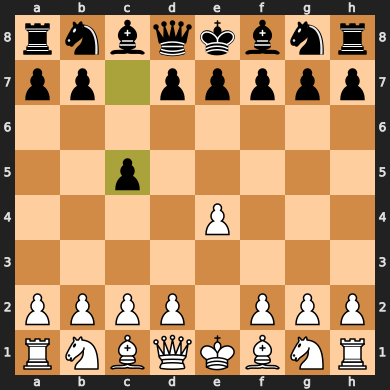

In [ ]:
# Player vs bot
move = get_move(game)
game.add_main_variation(move)
game = game.next()
if game.board().is_game_over():
    print("Game over")

move = get_bot_move()
if not move:
    print("No legal moves found")
game.add_main_variation(move)
game = game.next()
if game.board().is_game_over():
    print("Game over")
game.board()

In [ ]:
print(game)

1... c5


Enter move: e4e5


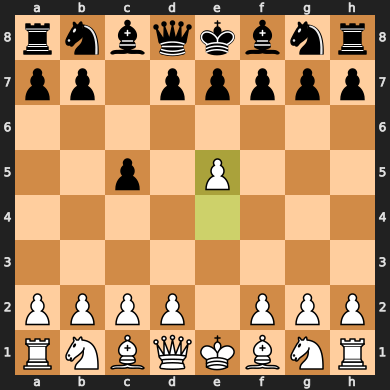

In [ ]:
# Player move
move = get_move(game)
game.add_main_variation(move)
game = game.next()
game.board()

Bot wants b8c6


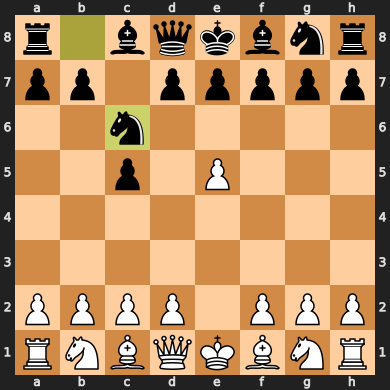

In [ ]:
# Bot move
move = get_bot_move()
if not move:
    print("No legal moves found")
game.add_main_variation(move)
game = game.next()
if game.board().is_game_over():
    print("Game over")
game.board()

In [ ]:
game.board().fen()

'r1bqkbnr/pp1ppppp/2n5/2p1P3/8/8/PPPP1PPP/RNBQKBNR w KQkq - 1 3'

In [ ]:
print(initial_game)

[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

1. e4 c5 2. e5 Nc6 *


# Predict move reinforcement

In [ ]:
class PlayerOfGames:
    def __init__(self, model, learning_rate):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def select_action(self, game):
        state, consts = game_to_tensor(game)
        state = (
            state.permute(2, 0, 1).unsqueeze(0).to(device)
        )  # Adds a batch dimension and moves to the device
        consts = consts.unsqueeze(0).to(device)
        probs = self.model(state, consts)
        action = torch.multinomial(probs, 1)
        return action.item(), probs

    def update_policy(self, final_reward, log_probs):
        # TODO are all the moves saved somewhere? if so, does it work?
        policy_loss = [-log_prob * final_reward for log_prob in log_probs]
        policy_loss = torch.stack(policy_loss).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

def play_game(player):
    board = chess.Board(fen="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")
    game = pgn.Game.from_board(board)
    log_probs = []

    illegal_move = False
    model_is_white = random.choice([True, False])
    if model_is_white:
        while True:
            if game.board().is_game_over():
                winner = game.board().outcome().winner
                if winner == chess.WHITE:
                    final_reward = 1
                elif winner == chess.BLACK:
                    final_reward = -1
                else:
                    final_reward = -0.2
                break

            action, probs = player.select_action(game)
            log_prob = torch.log(probs.squeeze(0)[action])

            one_hot = torch.zeros(probs.size(1))
            one_hot[action] = 1

            move = tensor_to_move(one_hot, game.board().turn)
            if move not in game.board().legal_moves:
                final_reward = -1
                illegal_move = True
                break

            game.add_main_variation(move)
            game = game.next()
            log_probs.append(log_prob)

            if game.board().is_game_over():
                continue
            print(game.board())
            move = get_move(game)
            game.add_main_variation(move)
            game = game.next()

        if illegal_move:
            # only discourage the last move
            # TODO
            pass

        return final_reward, log_probs
    while True:
        if game.board().is_game_over():
            winner = game.board().outcome().winner
            if winner == chess.WHITE:
                final_reward = 1
            elif winner == chess.BLACK:
                final_reward = -1
            else:
                final_reward = -0.2
            break

        print(game.board())
        move = get_move(game)
        game.add_main_variation(move)
        game = game.next()
        if game.board().is_game_over():
            continue

        action, probs = player.select_action(game)
        log_prob = torch.log(probs.squeeze(0)[action])

        one_hot = torch.zeros(probs.size(1))
        one_hot[action] = 1

        move = tensor_to_move(one_hot, game.board().turn)
        if move not in game.board().legal_moves:
            final_reward = -1
            illegal_move = True
            break

        game.add_main_variation(move)
        game = game.next()
        log_probs.append(log_prob)

    if illegal_move:
        # only discourage the last move
        # TODO
        pass

    return final_reward, log_probs

def train(player, num_episodes):
    for episode in range(num_episodes):
        final_reward, log_probs = play_game(player)
        player.update_policy(final_reward, log_probs)

        if episode % 10 == 0:
            print(f'Episode {episode}, Final Reward: {final_reward}')

player = PlayerOfGames(model, learning_rate=0.01)
train(player, num_episodes=1000)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Enter move: a2a4


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Eval position

In [ ]:
class ChessAIEval(ChessAISmaller):
    pass


def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

model = ChessAIEval()
model.apply(init_weights)
model.to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# A nice chess UI

In [ ]:
from IPython.display import display, HTML, Javascript
from google.colab.output import eval_js
import chess

# Initialize the chess board in Python
board = chess.Board()


# Python callback to handle updates from the JavaScript frontend
def update_move(fen):
    global board
    board.set_fen(fen)
    print(f"New fen: {board.fen()}")
    return fen

# Register the callback
from google.colab import output
output.register_callback("notebook.update_move", update_move)

In [ ]:
from IPython.display import display, HTML

js_for_chess = """
<link rel="stylesheet"
      href="https://unpkg.com/@chrisoakman/chessboardjs@1.0.0/dist/chessboard-1.0.0.min.css"
      integrity="sha384-q94+BZtLrkL1/ohfjR8c6L+A6qzNH9R2hBLwyoAfu3i/WCvQjzL2RQJ3uNHDISdU"
      crossorigin="anonymous">

<script src="https://code.jquery.com/jquery-3.5.1.min.js"
        integrity="sha384-ZvpUoO/+PpLXR1lu4jmpXWu80pZlYUAfxl5NsBMWOEPSjUn/6Z/hRTt8+pR6L4N2"
        crossorigin="anonymous"></script>

<script src="https://unpkg.com/@chrisoakman/chessboardjs@1.0.0/dist/chessboard-1.0.0.min.js"
        integrity="sha384-8Vi8VHwn3vjQ9eUHUxex3JSN/NFqUg3QbPyX8kWyb93+8AC/pPWTzj+nHtbC5bxD"
        crossorigin="anonymous"></script>

<div id="board1" style="width: 400px"></div>
<button id="startPositionBtn">Start Position</button>

<script>

function onChange (oldPos, newPos) {
  console.log(Chessboard.objToFen(newPos));\
  (async function() {
  const result = await google.colab.kernel.invokeFunction(
    'notebook.update_move', // The callback name.
    [Chessboard.objToFen(newPos)], // The arguments.
    {}); // kwargs
    })();
}

var config = {
  draggable: true,
  position: 'start',
  onChange: onChange,
  pieceTheme: 'https://raw.githubusercontent.com/oakmac/chessboardjs/refs/heads/master/website/img/chesspieces/uscf/{piece}.png'
}

var board = Chessboard('board1', config)
$('#startPositionBtn').on('click', board.start)
</script>
"""

display(HTML(js_for_chess))

New fen: rnbqkbnr/pppppppp/8/3P4/8/8/PPP1PPPP/RNBQKBNR w - - 0 1
New fen: rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR w - - 0 1
New fen: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1
New fen: rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR w - - 0 1
New fen: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1
